# NLP - Predict Client Evaluation

O problema consiste em prever a nota de avaliação dos clientes de um website de ecommerce, com base nos dados de avaliações (train_df.csv) com foco em aplicar NLP nos comentarios.

In [141]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot data
import sklearn # scikit-learn library, where the magic happens!
import seaborn as sns # beautiful graphs
import re # simple regex

# Dataset

Tabela de dados de empresa de ecommerce com mais de 130 mil avaliações de clientes. A base oferece informações sobre o perfil do revisor, como sexo, idade e localização geográfica.

In [142]:
train_df = pd.read_csv('data/train_df.csv')

In [143]:
print(train_df.shape)
print(train_df.columns)
train_df.head(5)

(105898, 15)
Index(['index', 'submission_date', 'reviewer_id', 'product_id', 'product_name',
       'product_brand', 'site_category_lv1', 'site_category_lv2',
       'review_title', 'recommend_to_a_friend', 'review_text',
       'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
       'overall_rating'],
      dtype='object')


,index,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
0,95851,2018-04-20 11:56:28,c951f3a4511b554a1f34330903c320f34cfccbdf8de357...,111586438,Depilador Elétrico Philips Satinelle HP6403/30,philips,Beleza e Perfumaria,Depilação,Depilador,Yes,Muito eficiente e prático! Depilação rápida em...,1978.0,F,ES,5
1,115536,2018-05-10 18:56:36,21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...,19399940,Hidratante Corporal Dior Addict Body Mist Femi...,NaN,Beleza e Perfumaria,Tratamento de Pele,Cheiro de rica,Yes,"Adoro o perfume que fica na pele, ele não é um...",1986.0,F,SP,5
2,1254,2018-01-02 07:02:48,eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...,22747780,Controle Com Fio Para Xbox 360 Slim / Fat E Pc...,NaN,Games,Xbox 360,Bom produto,Yes,funciona o que é importante bom produto o text...,1978.0,M,ES,3
3,86792,2018-04-11 16:45:45,e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...,22857850,Kit Edredom + Lençol Aconchego Dupla Face Casa...,NaN,"Cama, Mesa e Banho",Edredom,Nao recebi onprofuto e nem satisfacao,No,Gostaria de saber da minha entrega ate hoje na...,1969.0,F,RJ,1
4,35543,2018-02-02 16:30:23,420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...,132207708,Smartphone Motorola Moto E4 Dual Chip Android ...,motorola,Celulares e Smartphones,Smartphone,Excelente aquisição!,Yes,Entrega super rápida! Quando da compra tive c...,1965.0,M,PE,4


Ok, temos portanto mais de 100mil datapoints, com 15 colunas cada.

Pelo texto descritivo das colunas e conteudo das mesmas, podemos atribuir o seguinte significado em cada coluna:

- index: Provavelmente algum index especifico do banco de dados onde foram retiradas os datapoints
- submission_date: Data de subimissão da review
- reviewer_id: Id do revisor
- product_id: Id do produto
- product_name: Nome do produto
- product_brand: Marca do produto
- site_category_lv1: Categoria do produto utilizada na organização do site
- site_category_lv2: Categoria secundaria do produto utilizada na organização do site
- review_title: Titulo da review
- recommend_to_a_friend: 'Recomendaria o produto a um amigo?' (Boleana simples)
- review_text: Texto da review
- reviewer_birth_year: Ano de nascimento do revisor
- reviewer_gender: Genero do revisor
- reviewer_state: Estado (UF) do revisor
- overall_rating: Nota dada pelo revisor (Nosso objetivo de previsão)


# Outliers e similares

Vamos inicialmente verificar se temos algum datapoint repitido, informações faltantes, etc.

## Informações faltantes

In [144]:
outliers = train_df.isnull().sum().sort_values(ascending=False).to_frame(name='NaN values')
outliers['percent'] = outliers['NaN values']/train_df.shape[0]
outliers

,NaN values,percent
product_brand,73194,0.691175
reviewer_birth_year,4793,0.045261
reviewer_gender,3316,0.031313
site_category_lv2,3212,0.030331
reviewer_state,3207,0.030284
product_name,65,0.000614
recommend_to_a_friend,10,0.000094
site_category_lv1,3,0.000028
overall_rating,0,0.000000
review_text,0,0.000000


Uhhh, 70% do dataset não tem marca do produto. Dado o tamanho do valor, provavelmente sera melhor não considerar a coluna **product_brand**.
Os outros dados faltantes são menos do que 5% do dataset.

Ano de nascimento do revisor provavelmente deve ter correlação com a linguem utilizada, então faz sentido tentarmos completar os dados. Mesma coisa com genero (Embora esse provavelmente seja mais complicado).

**site_category_lv2** provavelmente tem as categorias primarias, então faz sentido não necesariamente termos a segunda.
**site_category_lv1** porem não termos a primeira categoria é preocupante.

**reviewer_state** podemos substituir com o estado mais presente.

**product_name** não termos o nome do produto cadastrado pode ser um indicativo de erro no site, melhor verificarmos alguns casos.

**recommend_to_a_friend** provavelmente sera um otimo preditor da nota final, e faz sentido não utilizarmos os valores não presentes

### Informações faltantes - product_brand

In [145]:
train_df[train_df['product_brand'].isnull()].head(5)

,index,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
1,115536,2018-05-10 18:56:36,21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...,19399940,Hidratante Corporal Dior Addict Body Mist Femi...,NaN,Beleza e Perfumaria,Tratamento de Pele,Cheiro de rica,Yes,"Adoro o perfume que fica na pele, ele não é um...",1986.0,F,SP,5
2,1254,2018-01-02 07:02:48,eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...,22747780,Controle Com Fio Para Xbox 360 Slim / Fat E Pc...,NaN,Games,Xbox 360,Bom produto,Yes,funciona o que é importante bom produto o text...,1978.0,M,ES,3
3,86792,2018-04-11 16:45:45,e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...,22857850,Kit Edredom + Lençol Aconchego Dupla Face Casa...,NaN,"Cama, Mesa e Banho",Edredom,Nao recebi onprofuto e nem satisfacao,No,Gostaria de saber da minha entrega ate hoje na...,1969.0,F,RJ,1
5,87388,2018-04-12 07:37:39,35befbf9c5cbbb715dbc77f1380c8dbc173f88e7f4774f...,29446699,Valvula Purificador Agua Philips WP3812,NaN,Eletroportáteis,Bebedouro e Purificador de Água,Venda enganosa,No,"Na foto consta o aparelho completo, porém para...",1986.0,M,SP,1
6,113630,2018-05-09 05:58:17,a69ceb8e59e3959d22ccae3187a1b20fd6c1f0f75cfa29...,33646613,Tênis Feminino Slip On Lantejoulas Moleca,NaN,Moda,Feminino,Produto não entregue,No,Minha avaliação aqui é da loja e não do produt...,1986.0,F,SP,1


Como podemos ver, a marca esta presente no nome do produto, o que provavelmente indica que o site não se preocupa tanto com a inclusão da marca.
Mas realmente não temos dados o suficiente pra justificar manter a coluna.

In [146]:
train_df.drop(columns='product_brand', inplace=True)

### Informações faltantes - site_category

In [147]:
train_df[train_df['site_category_lv1'].isnull()]

,index,submission_date,reviewer_id,product_id,product_name,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
4179,55792,2018-03-10 22:25:07,bf2c467d484a9a50fc2c59ce1b37e0edfa860ce28dc1b9...,6726115,Mini Processador Philips Walita HR 2939/00 par...,NaN,NaN,Muito bom,Yes,Tenho esse Mini Processador há no mínimo 4 ano...,1949.0,F,AM,3
70490,72596,2018-03-28 10:04:44,a16e0e9467a6a08456cc50efe03ae25668f95ad312a1e8...,6723598,CD Jonas Brothers - A Little Bit Longer,NaN,NaN,Muito bom,Yes,Recomendo!! Esse faltava pra minha coleção!! P...,1990.0,F,RJ,5
105427,124424,2018-05-20 21:22:17,fe2b1c6c051342b33a47bbc1fda762b56c4b0cee7230ff...,6726115,Mini Processador Philips Walita HR 2939/00 par...,NaN,NaN,ótimo,Yes,"Ótimo produto e super prático. Trituro alho, c...",1988.0,F,RJ,5


Ok, realmente não vejo motivo para manter esses datapoints.

In [148]:
train_df.dropna(subset = ['site_category_lv1'], inplace=True)

### Informações faltantes - reviewer_state

In [149]:
train_df[train_df['reviewer_state'].isnull()].head()

,index,submission_date,reviewer_id,product_id,product_name,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
55,29736,2018-01-24 18:51:30,ec5d35dd2e4153f5c1bc3fb48139b1b37819ef84ed2600...,27776244,Iron Man - Mark XLIII Quarter Scale - Avengers...,Brinquedos,Bonecos,Ótimo produto,Yes,Excelente produto! Ele voa e dispara laser. Da...,NaN,NaN,NaN,5
74,28288,2018-01-23 07:55:40,b320af9a9397148983866a4cee245111e6c3e128e94580...,23111043,Eliminadora E Removedora De Pontas Duplas - Preto,Beleza e Perfumaria,Barbearia,Veio com defeito,No,Tentei trocar o pruduto mais a loja não está d...,NaN,NaN,NaN,1
99,66665,2018-03-22 11:57:47,0d827cc26063d2b1cdca6feca4cd97b409368d278f698a...,10776951,Cortador De Comprimidos Transparente - Incoter...,Ferramentas e Jardim,Ferramentas Manuais,Muito bom! Vale cada centavo,Yes,"Muito bom gente! comprei e estou adorando, mui...",NaN,NaN,NaN,5
171,111046,2018-05-06 10:29:34,40be70c9e0c69eadeda96a7b6e096da24b4da924eedb12...,27287442,Kit 3 Unidades Dermaroller Drs 540 Micro Agulh...,Beleza e Perfumaria,Perfumaria,Gostei,Yes,"Falta instrução de como usar, essa parte ficou...",NaN,NaN,NaN,3
213,88858,2018-04-13 11:43:16,895027019f5f868eb0812668aad0a351614370aa64f9da...,15076975,Kit Iluminação DJ Festa Disco 110V,Instrumentos Musicais,Equipamento para DJ,Impossível avaliar o produto,No,Hoje está fazendo 1 mês que comprei o kit e a ...,NaN,NaN,NaN,1


In [150]:
train_df['reviewer_state'].value_counts(normalize=True).head()

SP    0.382070
RJ    0.137825
MG    0.128233
PR    0.052246
RS    0.050999
Name: reviewer_state, dtype: float64

Ok, parece razoavel presumir que 3% das informações de estado faltente possam ter vindo de São Paulo (Responsavel por 38% das reviews). Ou poderiamos dropar esses dados tambem dado a nossa quantidade de dados.

Optei por manter e substituir por SP.

In [151]:
train_df['reviewer_state'].fillna('SP', inplace = True)

### Informações faltantes - product_name

In [152]:
train_df[train_df['product_name'].isnull()].head(5)

,index,submission_date,reviewer_id,product_id,product_name,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
184,60896,2018-03-16 14:31:26,2b31b67f0ac96f01ab53fb6666487580d716711ade75ba...,2018031622,NaN,Miscellaneous,NaN,Produto excelente!,NaN,Produto excelente e entrega rápida! Recomendo!...,1986.0,M,RJ,5
1586,121754,2018-05-17 14:47:21,0cace25c90053d3c1b30dcb29724a2db4d6b8c65cf7e90...,21079289,NaN,Miscellaneous,NaN,Bom,Yes,O produto é bom porém pedi dos carros mas me e...,1981.0,F,SP,3
6774,86254,2018-04-11 08:31:40,75d0ab4067f1e4dc514f551d9480a48018b2ec516f7b38...,12317455,NaN,Miscellaneous,NaN,RUIDO,No,"FAZ UM RUÍDO QUANDO ESTÁ DORMINDO NA ÁGUA, VEN...",1979.0,M,BA,2
7158,120517,2018-05-16 09:54:32,529b6c404bc86f0a3ac20d73f4434778ea2a96b34b6e91...,11852065,NaN,Miscellaneous,NaN,Qualidade garantida!!!,Yes,"Para os amantes da pesca, a marca Laiglon por ...",1957.0,M,SP,5
8439,73670,2018-03-29 08:57:52,61f5c0ac81d759485b930de9bc65b163fe931be40cfce7...,11505843,NaN,Miscellaneous,NaN,NÃO ERA O QUE ESPERAVA,Yes,"MUITO MENOR DO QUE PENSEI, MESMO OLHANDO AS ME...",1973.0,F,SP,3


As reviews até parecem validas, mas ainda é muito estranho uma avaliação de um produto sem nome.
Dado a pequena quantidade de casos assim, melhor remover os datapoints.

In [153]:
train_df.dropna(subset = ['product_name'], inplace=True)

### Informações faltantes - recommend_to_a_friend 

In [154]:
train_df[train_df['recommend_to_a_friend'].isnull()]

,index,submission_date,reviewer_id,product_id,product_name,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating


Ok, pelo visto acabamos removendo os datapoints que não continham **recommend_to_a_friend** nas outras remoções.

## Feature Engineering

Bom, de cara temos alguns features que provavelmente vão ser interesantes.
Podemos verificar que alguns usuarios escrevem suas reviews utilizando somente letras Maiusculas, alguns praticamente não usam pontuação, etc. Tamanho do texto talvez seja um bom indicador.

Dado a baixa complexidade de gerar esses features, provavelmente faz sentido gerarmos agora, em vez de esperar termos uma baseline.

### Feature Engineering - Lenght, contagem de letras maiusculas e contagem de pontuação

In [155]:
# review_title
train_df['review_title_len'] = train_df['review_title'].str.len()
train_df['review_title_caps_len'] = train_df['review_title'].apply(lambda x: len(re.findall(r'[A-Z]', x)))
train_df['review_title_punct_len'] = train_df['review_title'].apply(lambda x: len(re.findall(r'[.:;,?!()\'\"-]', x)))

# review_text
train_df['review_text_len'] = train_df['review_text'].str.len()
train_df['review_text_caps_len'] = train_df['review_text'].apply(lambda x: len(re.findall(r'[A-Z]', x)))
train_df['review_text_punct_len'] = train_df['review_text'].apply(lambda x: len(re.findall(r'[.:;,?!()\'\"-]', x)))

print('Review Title com muitas pontuações:')
print(train_df[train_df['review_title_punct_len']>50]['review_title'].head(5))
print('\nReview Text com muitas pontuações:')
print(train_df[train_df['review_text_punct_len']>50]['review_text'].head(5))

Review Title com muitas pontuações:
10281    EU QUERO RECEBER ANTES DE AVALIAAAAAAAAAAAAAAA...
16225    .................................................
17326    .................................................
24663    ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
52613    bom .............................................
Name: review_title, dtype: object

Review Text com muitas pontuações:
116    muito bom .......................................
128    produto bom......................................
309    NÃO RECEBI O PRODUTO que estava marcado pra se...
316    Porque não recomendo este produto:  1) O produ...
949    Show!! é muito bom! issso aí! Recomendo!! comp...
Name: review_text, dtype: object


Ok, aparentemente é um comportamento dos revisores a adição de pontuação simplesmente com o objetivo de preencher espaço.
O numero de pontuação provavelmente pode ser um preditor da nota da review, mas tambem existe uma chance razoavel do nosso algoritimo ter problemas com a analise de tanta pontuação.

### Feature Engineering - Idade do revisor, dia da semana e horario

Temos a data de nascimento e a data de postagem, e a linguagem utilizada provavelmente depende da idade do revisor.

In [156]:
#reviewer_birth_year
train_df['submission_date'] = pd.to_datetime(train_df['submission_date'])
train_df['reviewer_age'] = train_df['submission_date'].dt.year - train_df['reviewer_birth_year']

In [157]:
train_df[train_df['reviewer_age']>100]['reviewer_age'].value_counts()

118.0     17
1957.0     2
110.0      2
113.0      2
107.0      2
112.0      2
102.0      1
104.0      1
1933.0     1
111.0      1
109.0      1
1959.0     1
1940.0     1
119.0      1
101.0      1
1947.0     1
1935.0     1
1930.0     1
103.0      1
Name: reviewer_age, dtype: int64

In [158]:
train_df[train_df['reviewer_age']<15]['reviewer_age'].value_counts()

14.0    17
8.0     11
12.0     9
13.0     9
9.0      8
11.0     5
10.0     4
1.0      4
0.0      1
Name: reviewer_age, dtype: int64

Me parece pouco provavel que tenhamos usuarios com mais de 100 anos colocando reviews. E com certeza não temos usuarios com 1957 anos.
Tambem parece estranho usuarios com 1 e 0 anos.

Pra simplificar, vamos simplesmente colocar a media de idade no lugar de idades com mais de 100 anos e nas idades de 0 e 1 anos.

In [159]:
mean_age = train_df.loc[(train_df['reviewer_age']<100) & (train_df['reviewer_age']>5), ['reviewer_age']].mean()
train_df.loc[train_df['reviewer_age']>100, ['reviewer_age']] = mean_age
train_df.loc[train_df['reviewer_age']==1, ['reviewer_age']] = mean_age
train_df.loc[train_df['reviewer_age']==0, ['reviewer_age']] = mean_age

Talvez tambem exista alguma correlação entre dia da semana ou horario com a nota da review. (Pessoas talvez façam mais comentarios possitivos na sexta feira ou postem comentarios possitivos principalmente pela manha, etc).

In [160]:
#review_weekday - Assume-se que a semana começa na segunda, logo segundas são denominadas '0' e domingos denominados '6'
train_df['review_weekday'] = train_df['submission_date'].dt.weekday

#review_hour
train_df['review_hour'] = train_df['submission_date'].dt.hour

## Analize de correlação

Ok, resolvemos os problemas mais gritantes de dados faltantes e outliers que indentificamos ate o momento. E criamos alguns features basicos.
Agora faz sentido uma analise basica de correlação das nossas variaveis antes de tentar desenvolver a nossa primeira maquina.

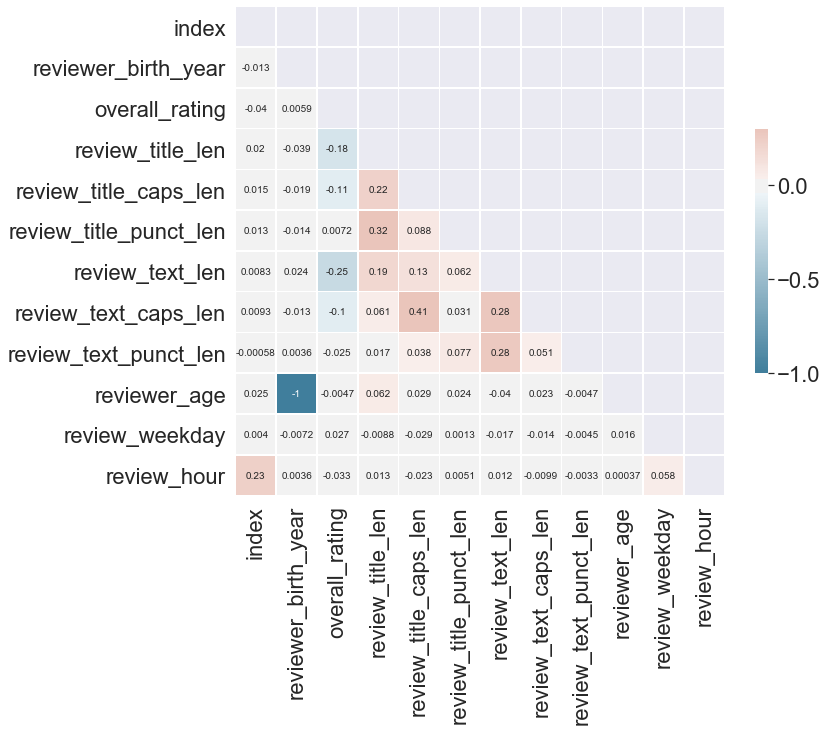

In [161]:
# Tabela de correlação e geração de mascara.
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, mask=mask, vmax=.3, center=0, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 10})

Legal, os features que criamos com base nos textos tem uma correlação melhor do que as outras variaveis presentes.

Porem, algumas variaveis talvez tenham alguma correlação, e uma matriz de correlação simplesmente não seja o melhor jeito de realizar essa analise (Caso das variaveis **review_weekday** e **review_hour**)

### review_weekday

[Text(0, 0.5, 'Rating'), Text(0.5, 0, 'WeekDay')]

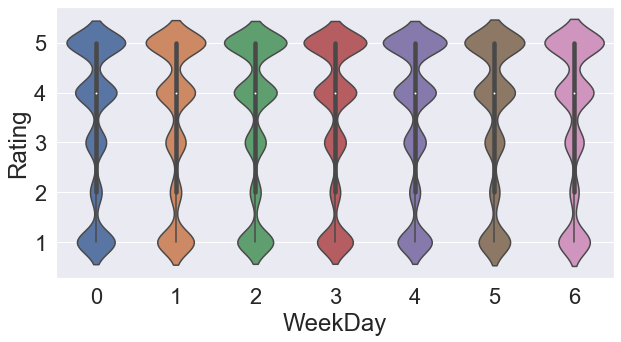

In [162]:
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(10, 5))

ax = sns.violinplot(x='review_weekday',y='overall_rating',orient='v',data=train_df,fliersize=8)
ax.set(xlabel='WeekDay', ylabel='Rating')

Ok, nosso feature de dia da semana provavelmente não tem nenhuma correlação com a nota da review.

### review_hour

[Text(0, 0.5, 'Hour'), Text(0.5, 0, 'Rating')]

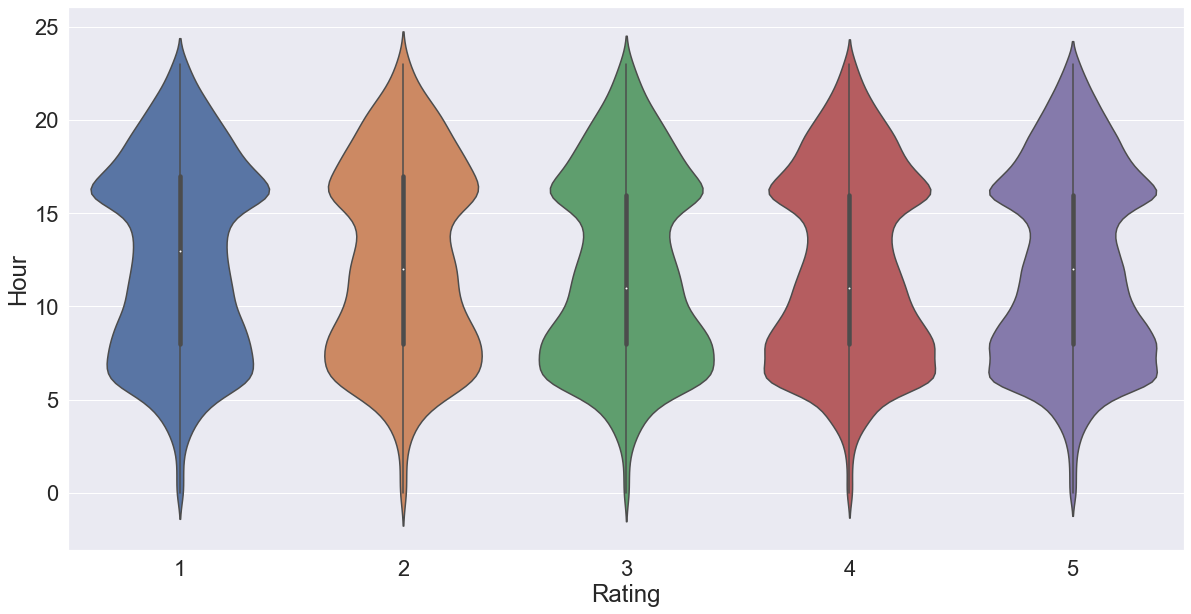

In [163]:
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20, 10))

ax = sns.violinplot(x='overall_rating',y='review_hour',orient='v',data=train_df,fliersize=8)
ax.set(xlabel='Rating', ylabel='Hour')

Ok, ate existe alguma leve relação ai entre o horario e a nota, mas não é nada significativo.

Agora claramente existe uma correlação entre horario e post de review. Os usuarios aparentemente postam mais reviews no começo da manha (7-8h) e no meio da tarde (16h).

### review_age

[Text(0, 0.5, 'Years'), Text(0.5, 0, 'Rating')]

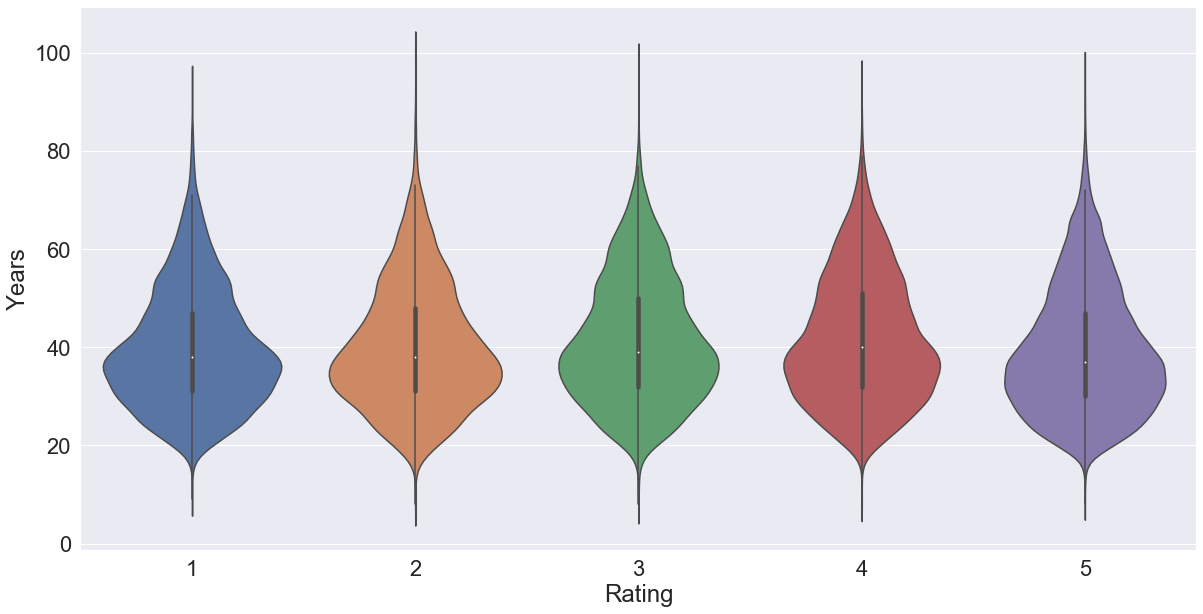

In [166]:
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20, 10))

ax = sns.violinplot(x='overall_rating',y='reviewer_age',orient='v',data=train_df,fliersize=8)
ax.set(xlabel='Rating', ylabel='Years')

Ok, nenhuma correlação identificavel com a idade tambem.

### Analise de correlação - Conclusão

Não identificamos nenhuma correlação significativa entre as variaveis não ligadas diretamente com o texto.
Porem a boa noticia é que os features que criamos com base no texto apresentam alguma correlação com o rating.